In [8]:
%reset -f
import ROOT
import traceback
import sys
from MyCommonAnalysisFunction_richcap import *
from Convert_MultiDim_Kinematic_Bins  import *
from ExtraAnalysisCodeValues          import *
from array                            import array
from datetime                         import datetime

script_dir = '/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/RC_Correction_Code'
sys.path.append(script_dir)
from Find_RC_Fit_Params import Find_RC_Fit_Params, Apply_RC_Factor_Corrections, Get_RC_Fit_Plot
sys.path.remove(script_dir)
del script_dir

def variable_Title_name_new(variable_in):
    if(variable_in in ["k0_cut"]):
        return "E^{Cutoff}_{#gamma}"
    else:
        output = variable_Title_name(variable_in)
        output = output.replace(" (lepton energy loss fraction)", "")
        return output

ROOT.TH1.AddDirectory(0)
ROOT.gStyle.SetTitleOffset(1.3,'y')
ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetStatX(0.80)  # Set the right edge of the stat box (NDC)
ROOT.gStyle.SetStatY(0.45)  # Set the top edge of the stat box (NDC)
ROOT.gStyle.SetStatW(0.3)   # Set the width of the stat box (NDC)
ROOT.gStyle.SetStatH(0.2)   # Set the height of the stat box (NDC)


print(f"{color.BOLD}\nStarting RG-A SIDIS Analysis\n{color.END}")

Relative_Background_Run_Q = False



Starting RG-A SIDIS Analysis



In [9]:
import re

def parse_key(name):
    # Extract everything inside parentheses
    parts = re.findall(r"\((.*?)\)", name)
    if(len(parts) < 6):
        return None  # doesn't match expected 6-part convention
    
    return {
        "type_in"  : parts[0],
        "source"   : parts[1],
        "smear"    : parts[2],
        "Q2_y_bin" : parts[3],
        "z_pT_bin" : parts[4],
        "variable" : parts[5],
    }


def search_keys(type_in=None, source=None, smear=None, Q2_y_bin=None, z_pT_bin=None, variable=None, type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=False, verbose_odd=False, max_show=None, general_include=None, general_exclude=None):
    matches    = []
    nonconform = []

    for k in all_keys:

        if(type(general_include)    is     list):
            if(any(str(include) not in    str(k) for              include      in general_include)):
                continue
        else:
            if((general_include     is not None) and (str(general_include) not in str(k))):
                continue
        if(type(general_exclude)    is     list):
            if(any(str(exclude)     in    str(k) for              exclude      in general_exclude)):
                continue
        else:
            if((general_exclude     is not None) and (str(general_exclude)     in str(k))):
                continue
                
        
        parsed = parse_key(k)
        if(parsed is None):
            nonconform.append(k)
            continue

        if((type_in  is not None) and (parsed["type_in"]  not in type_in)):  continue
        if((source   is not None) and (parsed["source"]   not in source)):   continue
        if((smear    is not None) and (parsed["smear"]    not in smear)):    continue
        if((Q2_y_bin is not None) and (parsed["Q2_y_bin"] not in Q2_y_bin)): continue
        if((z_pT_bin is not None) and (parsed["z_pT_bin"] not in z_pT_bin)): continue
        if((variable is not None) and (parsed["variable"] not in variable)): continue

        if(parsed["type_in"]  in type_in_filter):  continue
        if(parsed["source"]   in source_filter):   continue
        if(parsed["Q2_y_bin"] in Q2_y_bin_filter): continue
        if(parsed["z_pT_bin"] in z_pT_bin_filter): continue
        if(parsed["variable"] in variable_filter): continue

        matches.append(k)


    if(verbose):
        print(f"Found {len(matches)} matches")
        if(max_show is None):
            for m in matches:
                print("  ", m)
        else:
            for m in matches[:max_show]:
                print("  ", m)
            if(len(matches) > max_show):
                print(f"  ... {len(matches) - max_show} more not shown ...")
            
    if(verbose_odd):
        if(len(nonconform) > 0):
            print(f"\n{len(nonconform)} nonconforming keys:")
            if(max_show is None):
                for m in nonconform:
                    print("  ", m)
            else:
                for m in nonconform[:max_show]:
                    print("  ", m)
                if(len(nonconform) > max_show):
                    print(f"  ... {len(nonconform) - max_show} more not shown ...")

    return matches


def list_unique_options(max_show=None):
    types, sources, variables = set(), set(), set()
    nonconform = []

    for k in all_keys:
        parsed = parse_key(k)
        if(parsed is None):
            nonconform.append(k)
            continue
        types.add(parsed["type_in"])
        sources.add(parsed["source"])
        variables.add(parsed["variable"])

    def print_list(label, items):
        items_sorted = sorted(items)
        if(max_show is None):
            print(f"{label}: {items_sorted}")
        else:
            print(f"{label}: {items_sorted[:max_show]}")
            if(len(items_sorted) > max_show):
                print(f"  ... {len(items_sorted) - max_show} more not shown ...")

    print("    Unique Types:",     sorted(types))
    print("  Unique Sources:",     sorted(sources))
    print("Unique Variables:",     sorted(variables))
    if(len(nonconform) > 0):
        print(f"\n{len(nonconform)} nonconforming keys (ignored).")

print("Done")

Done


In [10]:
TTree_Name = "Unfolded_Histos_From_Just_RooUnfold_SIDIS_richcap_Lower_Acceptance_Cut.root"
print(f"\n{color.BBLUE}Using Existing TTree {color.END_B}(File is: {color.UNDERLINE}{TTree_Name}{color.END_B}){color.END}\n")
TTree_Input = ROOT.TFile.Open(TTree_Name, "READ")

all_keys = [key.GetName() for key in TTree_Input.GetListOfKeys()]
print(f"Total keys found: {len(all_keys)}")


# Show all Q2=Q2_y_Bin_3 histograms from source "rdf"
# results = search_keys(source="rdf", Q2_y_bin="Q2_y_Bin_3", verbose=True)

results = search_keys(type_in=["Normal_2D"], source=["rdf"], smear=None, Q2_y_bin=["Q2_y_Bin_All", "Q2_y_Bin_5"], z_pT_bin=["z_pT_Bin_All"], variable=["Q2", "z"], type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=False, max_show=None, general_include=None, general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", "(Q2_y_Bin_5)_(z_pT_Bin_All)_(Q2)_(y)"])

print("\n\n===================================================================================================================================\n\n")

# Get unique naming options
list_unique_options()

print("\n\n===================================================================================================================================\n\n")

print("Done")

# # List_of_All_Histos_For_Unfolding = {}
# count = 0
# # length_of_name = 0
# for key in TTree_Input.GetListOfKeys():
#     key_name = key.GetName()
#     if(not Relative_Background_Run_Q):
#         Relative_Background_Run_Q = "Relative_Background" in str(key_name)
#     if("TList_of_" in key_name):
#         count += len([float(str(item.GetString())) for item in TTree_Input.Get(key_name)])
#         pass
#         # List_of_All_Histos_For_Unfolding[key_name] = [float(str(item.GetString())) for item in TTree_Input.Get(key_name)]
#     else:
#         if("Q2_y_Bin_5" in str(key_name)):
#             print(f"\t{count:>5}) {key_name:<112}-> {type(TTree_Input.Get(key_name))}")
#         # length_of_name = max([length_of_name, len(str(key_name))])
#         count += 1
#         # List_of_All_Histos_For_Unfolding[key_name] = TTree_Input.Get(key_name)
# TTree_Input.Close()
# print(f"\n{color.BBLUE}Recovered: {color.BGREEN}{count}{color.END_B}{color.BLUE} items{color.END}")
# # print(f"\n{color.BOLD}length_of_name = {length_of_name}{color.END}\n")


Using Existing TTree (File is: Unfolded_Histos_From_Just_RooUnfold_SIDIS_richcap_Lower_Acceptance_Cut.root)

Total keys found: 52754




    Unique Types: ['1D', 'MultiDim_3D_Histo', 'Normal_2D', 'Normal_Background_2D', 'Response_Matrix']
  Unique Sources: ['Acceptance', 'Background', 'Bayesian', 'Bin', 'bbb', 'gdf', 'mdf', 'rdf']
Unique Variables: ['MM', 'MultiDim_z_pT_Bin_Y_bin_phi_t', 'Q2', 'el', 'elPhi', 'elth', 'phi_t', 'pip', 'pipPhi', 'pipth', 'z', 'z_pT_Bin_All']

8 nonconforming keys (ignored).




Done


In [25]:
root_color.Bold

'#font[22]'

# Making 2D Histograms for Q2 vs y and z vs pT

In [7]:
Q2_Y_BIN = 5

z_pT_Orientation = "z_pT"
# z_pT_Orientation = "pT_z"

# Q2_y_Histo_rdf_Initial_Name, z_pT_Histo_rdf_Initial_Name = search_keys(type_in=["Normal_2D"], source=["rdf"], smear=None, Q2_y_bin=["Q2_y_Bin_All", f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=["z_pT_Bin_All"], variable=["Q2", "z"], type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=False, max_show=None, general_include=None, general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_{Q2_Y_BIN})_(z_pT_Bin_All)_(Q2)_(y)"])
Q2_y_Histo_rdf_Initial_Name, z_pT_Histo_rdf_Initial_Name = search_keys(type_in=["Normal_2D"], source=["rdf"], smear=None, Q2_y_bin=["Q2_y_Bin_All", f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=["z_pT_Bin_All"], variable=["Q2", "z"], type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=False, max_show=None, general_include=None, general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_All)_(z_pT_Bin_All)_(Q2)_(y)"])

print(f"Q2_y_Histo_rdf_Initial_Name = {Q2_y_Histo_rdf_Initial_Name}")
print(f"z_pT_Histo_rdf_Initial_Name = {z_pT_Histo_rdf_Initial_Name}")

Q2_y_Histo_rdf_Initial = TTree_Input.Get(Q2_y_Histo_rdf_Initial_Name)
z_pT_Histo_rdf_Initial = TTree_Input.Get(z_pT_Histo_rdf_Initial_Name)
Drawing_Histo_Set = {}
######################################################### ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
##===============##     3D Slices     ##===============## ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
if("3D" in str(type(Q2_y_Histo_rdf_Initial))):
    # bin_Histo_2D_0, bin_Histo_2D_1 = Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(0), Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(Q2_y_Histo_rdf_Initial.GetNbinsX())
    bin_Histo_2D_0, bin_Histo_2D_1 = Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(1), Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(Q2_y_Histo_rdf_Initial.GetNbinsX())
    Q2_y_Histo_rdf_Initial.GetXaxis().SetRange(bin_Histo_2D_0, bin_Histo_2D_1)
    Q2_y_Name = str(Q2_y_Histo_rdf_Initial.GetName())
    Drawing_Histo_Set[Q2_y_Name] = Q2_y_Histo_rdf_Initial.Project3D('yz e')
    Drawing_Histo_Set[Q2_y_Name].SetName(Q2_y_Name)
    Drawing_Histo_Set[Q2_y_Name].SetTitle("#font[22]{#splitline{CLAS12 RG-A Experimental Data}{Q^{2} vs y}}; y; Q^{2}")
else:
    Q2_y_Name = str(Q2_y_Histo_rdf_Initial.GetName())
    Drawing_Histo_Set[Q2_y_Name] = Q2_y_Histo_rdf_Initial
    print(f"Using Q2_y_Histo_rdf_Initial = {Q2_y_Histo_rdf_Initial}")
    Drawing_Histo_Set[Q2_y_Name].SetTitle("#font[22]{#splitline{CLAS12 RG-A Experimental Data}{Q^{2} vs y}}; y; Q^{2}")
Drawing_Histo_Set[Q2_y_Name].GetXaxis().SetRangeUser(0.2, 0.8)
if("Q2_y_Bin_All" not in Q2_y_Histo_rdf_Initial_Name):
    Drawing_Histo_Set[Q2_y_Name].GetYaxis().SetRangeUser(1.5, 9.5)
else:
    Drawing_Histo_Set[Q2_y_Name].GetYaxis().SetRangeUser(1.5,  12)
if("3D" in str(type(z_pT_Histo_rdf_Initial))):
    bin_Histo_2D_0, bin_Histo_2D_1 = z_pT_Histo_rdf_Initial.GetXaxis().FindBin(0), z_pT_Histo_rdf_Initial.GetXaxis().FindBin(z_pT_Histo_rdf_Initial.GetNbinsX())
    z_pT_Histo_rdf_Initial.GetXaxis().SetRange(bin_Histo_2D_0, bin_Histo_2D_1)
    z_pT_Name = str(z_pT_Histo_rdf_Initial.GetName())
    if(z_pT_Orientation in ["z_pT"]):
        Drawing_Histo_Set[z_pT_Name] = z_pT_Histo_rdf_Initial.Project3D('yz e')
        Drawing_Histo_Set[z_pT_Name].SetName(z_pT_Name)
        Drawing_Histo_Set[z_pT_Name].SetTitle(f"#font[22]{{#splitline{{#splitline{{CLAS12 RG-A Experimental Data}}{{z vs P_{{T}}}}}}{{Q^{{2}}-y Bin: {Q2_Y_BIN}}}}}; P_{{T}}; z")
    else:
        Drawing_Histo_Set[z_pT_Name] = z_pT_Histo_rdf_Initial.Project3D('zy e')
        Drawing_Histo_Set[z_pT_Name].SetName(z_pT_Name)
        Drawing_Histo_Set[z_pT_Name].SetTitle(f"#font[22]{{#splitline{{#splitline{{CLAS12 RG-A Experimental Data}}{{z vs P_{{T}}}}}}{{Q^{{2}}-y Bin: {Q2_Y_BIN}}}}}; z; P_{{T}}")
else:
    z_pT_Name = str(z_pT_Histo_rdf_Initial.GetName())
    Drawing_Histo_Set[z_pT_Name] = z_pT_Histo_rdf_Initial
    print(f"Using z_pT_Histo_rdf_Initial = {z_pT_Histo_rdf_Initial}")
    if(z_pT_Orientation in ["z_pT"]):
        Drawing_Histo_Set[z_pT_Name].SetTitle(f"#font[22]{{#splitline{{#splitline{{CLAS12 RG-A Experimental Data}}{{z vs P_{{T}}}}}}{{Q^{{2}}-y Bin: {Q2_Y_BIN}}}}}; P_{{T}}; z")
    else:
        Drawing_Histo_Set[z_pT_Name].SetTitle(f"#font[22]{{#splitline{{#splitline{{CLAS12 RG-A Experimental Data}}{{z vs P_{{T}}}}}}{{Q^{{2}}-y Bin: {Q2_Y_BIN}}}}}; z; P_{{T}}")
if(z_pT_Orientation in ["z_pT"]):
    Drawing_Histo_Set[z_pT_Name].GetXaxis().SetRangeUser(0, 1.4)
    Drawing_Histo_Set[z_pT_Name].GetYaxis().SetRangeUser(0,   1)
else:
    Drawing_Histo_Set[z_pT_Name].GetXaxis().SetRangeUser(0,   1)
    Drawing_Histo_Set[z_pT_Name].GetYaxis().SetRangeUser(0, 1.9)


canvas = ROOT.TCanvas("c", "Histogram Canvas", 900, 1000)

canvas.Draw()

ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetRightMargin(0.15)  # increase from default ~0.1


Drawing_Histo_Set[Q2_y_Name].Draw("COLZ")
Q2_y_borders = {}
for Q2_Y_Bin_ii in range(1, 18, 1):
    Q2_y_borders[Q2_Y_Bin_ii] = Draw_Q2_Y_Bins(Input_Bin=Q2_Y_Bin_ii)
    for line in Q2_y_borders[Q2_Y_Bin_ii]:
        line.Draw("same")
if(Q2_Y_BIN in range(1,18)):
    for line_Bin in Q2_y_borders[Q2_Y_BIN]:
        line_Bin.SetLineColor(ROOT.kRed)
        line_Bin.SetLineWidth(6)
        line_Bin.Draw("same")

line1 = ROOT.TLatex(0.5, 0.96, "CLAS12 RG-A Experimental Data")
line1.SetNDC(True)
line1.SetTextAlign(23)   # 2 = center horizontally, 3 = top align vertically
line1.SetTextFont(22)
line1.SetTextSize(0.06)
line1.Draw()

line2 = ROOT.TLatex(0.5, 0.89, "Q^{2} vs y")
line2.SetNDC(True)
line2.SetTextAlign(23)   # same centering, stacked below
line2.SetTextFont(22)
line2.SetTextSize(0.06)
line2.Draw()

if("Q2_y_Bin_All" not in Q2_y_Histo_rdf_Initial_Name):
    line3 = ROOT.TLatex(0.5, 0.825, f"Q^{{2}}-y Bin: {Q2_Y_BIN}")
    line3.SetNDC(True)
    line3.SetTextAlign(23)   # same centering, stacked below
    line3.SetTextFont(22)
    line3.SetTextSize(0.05)
    line3.Draw()


prelim = ROOT.TLatex(0.5, 0.5, "PRELIMINARY")
prelim.SetNDC(True)                         # position in normalized coordinates
prelim.SetTextAlign(22)                     # center horizontally & vertically
prelim.SetTextSize(0.125)                    # adjust size to taste
prelim.SetTextColorAlpha(ROOT.kRed, 0.1)    # red, 90% transparent (alpha = 0.1)
prelim.SetTextAngle(-30)                     # rotate 30 degrees
prelim.Draw()

canvas.Update()


canvas_z_pT = ROOT.TCanvas("c_z_pT", "Histogram Canvas", 900, 1000)

canvas_z_pT.Draw()

ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetRightMargin(0.15)  # increase from default ~0.1

Drawing_Histo_Set[z_pT_Name].Draw("COLZ")
if(str(Q2_Y_BIN) not in ["All", "0"]):
    # Drawing_Histo_Set[z_pT_Name].GetXaxis().SetRangeUser(0, 1.2)
    Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_Y_BIN, Set_Max_Y=1.2, Set_Max_X=1.2, Plot_Orientation_Input=z_pT_Orientation)
    
        
    MM_z_pT_borders = {}
    # MM_z_pT_legend = ROOT.TLegend(0.5, 0.1, 0.9, 0.2)
    MM_z_pT_legend = ROOT.TLegend(0, 0, 0, 0)
    MM_z_pT_legend.SetNColumns(2)
    MM_z_pT_borders, MM_z_pT_legend = Draw_the_MM_Cut_Lines(MM_z_pT_legend, MM_z_pT_borders, Q2_Y_BIN, z_pT_Orientation)
    for MM_lines in MM_z_pT_borders:
        MM_z_pT_borders[MM_lines].Draw("same")
    # MM_z_pT_legend.Draw("same")


rows = 6
row_current = 0
colors = [2, 4, 6, 8, 28, 30, 42]
Total_Number_of_Bins, Migration_Bin_1, Migration_Bin_2 = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_Y_BIN)
for z_pT in range(1, Total_Number_of_Bins + 1, 1):
    if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_BIN, Z_PT_BIN=z_pT, BINNING_METHOD="_Y_bin")):
        continue
    if((z_pT - (row_current*rows)) > rows):
        row_current += 1
    if(z_pT_Orientation == "pT_z"):
        color_row = colors[(z_pT - (row_current*rows))-1]
    else:
        color_row = colors[row_current]
    # print(f"{z_pT:>2} -> {color_row:>2}")
    Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_Y_BIN, Set_Max_Y=1.2, Set_Max_X=1.2, Plot_Orientation_Input=z_pT_Orientation, Select_z_pT_bin=z_pT, Select_color=color_row, Select_size=4)

line1_z_pT = ROOT.TLatex(0.5, 0.96, "CLAS12 RG-A Experimental Data")
line1_z_pT.SetNDC(True)
line1_z_pT.SetTextAlign(23)   # 2 = center horizontally, 3 = top align vertically
line1_z_pT.SetTextFont(22)
line1_z_pT.SetTextSize(0.06)
line1_z_pT.Draw()

line2_z_pT = ROOT.TLatex(0.5, 0.89, "z vs P_{T}")
line2_z_pT.SetNDC(True)
line2_z_pT.SetTextAlign(23)   # same centering, stacked below
line2_z_pT.SetTextFont(22)
line2_z_pT.SetTextSize(0.06)
line2_z_pT.Draw()

line3_z_pT = ROOT.TLatex(0.5, 0.84, f"Q^{{2}}-y Bin: {Q2_Y_BIN}")
line3_z_pT.SetNDC(True)
line3_z_pT.SetTextAlign(23)   # same centering, stacked below
line3_z_pT.SetTextFont(22)
line3_z_pT.SetTextSize(0.05)
line3_z_pT.Draw()

prelim_z_pT = ROOT.TLatex(0.5, 0.5, "PRELIMINARY")
prelim_z_pT.SetNDC(True)                         # position in normalized coordinates
prelim_z_pT.SetTextAlign(22)                     # center horizontally & vertically
prelim_z_pT.SetTextSize(0.125)                    # adjust size to taste
prelim_z_pT.SetTextColorAlpha(ROOT.kRed, 0.1)    # red, 90% transparent (alpha = 0.1)
prelim_z_pT.SetTextAngle(-30)                     # rotate 30 degrees
prelim_z_pT.Draw()



canvas_z_pT.Update()


print("Done")

Q2_y_Histo_rdf_Initial_Name = (Normal_2D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_All)_(Q2)_(y)
z_pT_Histo_rdf_Initial_Name = (Normal_2D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_All)_(z)_(pT)
Done


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_z_pT


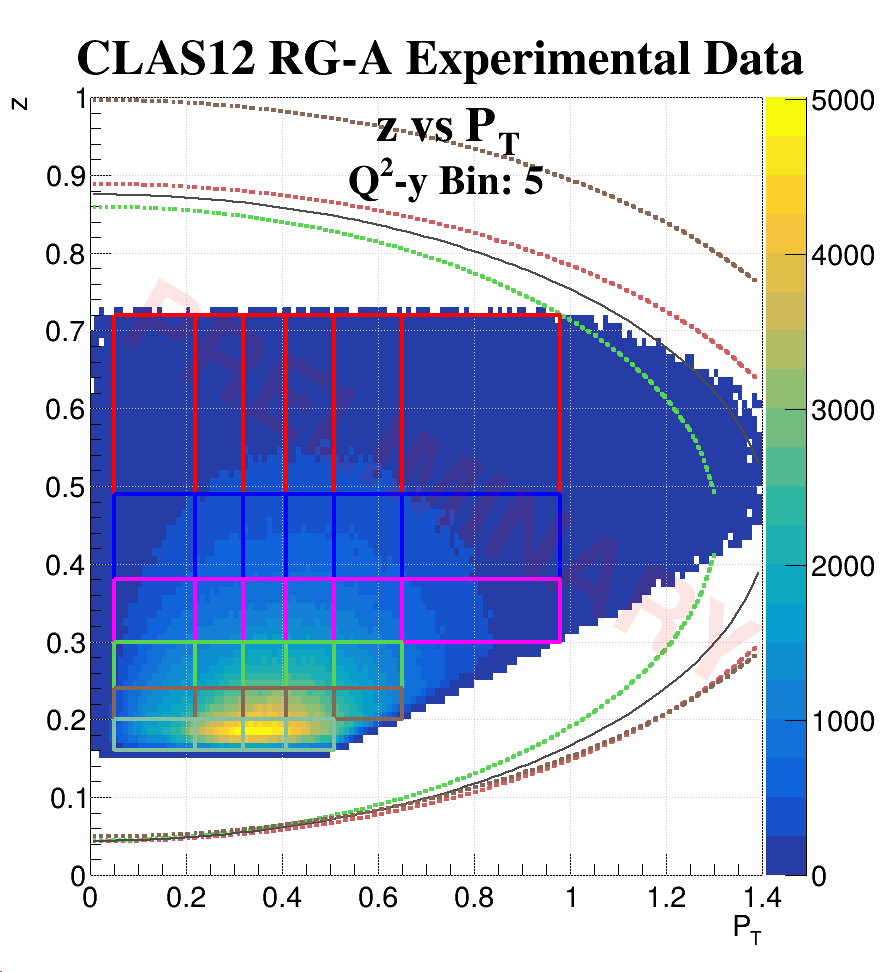

In [6]:
# canvas.Draw()
canvas_z_pT.Draw()

# Making 1D φh Plots

## Data and MC Normalized Comparisons

In [110]:
Q2_Y_BIN = 5
Z_PT_BIN = 16

# Q2_y_Histo_rdf_Initial_Name, z_pT_Histo_rdf_Initial_Name 
# results = search_keys(type_in=["1D"], source=["rdf", "mdf", "gdf"], smear=None, Q2_y_bin=[f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=[f"z_pT_Bin_{Z_PT_BIN}"], variable=["phi_t"], type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=not False, max_show=None, general_include=None, general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_{Q2_Y_BIN})_(z_pT_Bin_All)_(Q2)_(y)"])
rdf_Initial_Name, mdf_Initial_Name, gdf_Initial_Name = search_keys(type_in=["1D"], source=["rdf", "mdf", "gdf"], smear=None, Q2_y_bin=[f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=[f"z_pT_Bin_{Z_PT_BIN}"], variable=None, type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=not False, max_show=None, general_include=["phi_t"], general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_{Q2_Y_BIN})_(z_pT_Bin_All)_(Q2)_(y)"])

print(f"rdf_Initial_Name = {rdf_Initial_Name}")
print(f"mdf_Initial_Name = {mdf_Initial_Name}")
print(f"gdf_Initial_Name = {gdf_Initial_Name}")

# canvas_phi = ROOT.TCanvas("c_phi", "Histogram Canvas", 788, 750)
canvas_phi = ROOT.TCanvas("c_phi", "Histogram Canvas", 1050, 1000)

canvas_phi.Draw()

ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetRightMargin(0.05)  # increase from default ~0.1

rdf_Initial = TTree_Input.Get(rdf_Initial_Name)
mdf_Initial = TTree_Input.Get(mdf_Initial_Name)
gdf_Initial = TTree_Input.Get(gdf_Initial_Name)

ExREAL_1D_Norm = rdf_Initial.DrawNormalized("H P E0 same")
MC_REC_1D_Norm = mdf_Initial.DrawNormalized("H P E0 same")
MC_GEN_1D_Norm = gdf_Initial.DrawNormalized("H P E0 same")

Max_Pre_Unfolded = max([ExREAL_1D_Norm.GetBinContent(ExREAL_1D_Norm.GetMaximumBin()), MC_REC_1D_Norm.GetBinContent(MC_REC_1D_Norm.GetMaximumBin()), MC_GEN_1D_Norm.GetBinContent(MC_GEN_1D_Norm.GetMaximumBin())])

ExREAL_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)
MC_REC_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)
MC_GEN_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)

ExREAL_1D_Norm.GetXaxis().SetRangeUser(0, 360)
MC_REC_1D_Norm.GetXaxis().SetRangeUser(0, 360)
MC_GEN_1D_Norm.GetXaxis().SetRangeUser(0, 360)
    
# ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
ExREAL_1D_Norm.SetLineColor(root_color.Blue)
ExREAL_1D_Norm.SetLineWidth(2)
ExREAL_1D_Norm.SetLineStyle(1)
ExREAL_1D_Norm.SetMarkerColor(root_color.Blue)
ExREAL_1D_Norm.SetMarkerSize(1)
ExREAL_1D_Norm.SetMarkerStyle(21)
#####==========#####      MC REC Histogram       #####==========##### ################################################################
# ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
MC_REC_1D_Norm.SetLineColor(root_color.Red)
MC_REC_1D_Norm.SetLineWidth(2)
MC_REC_1D_Norm.SetLineStyle(1)
MC_REC_1D_Norm.SetMarkerColor(root_color.Red)
MC_REC_1D_Norm.SetMarkerSize(1)
MC_REC_1D_Norm.SetMarkerStyle(22)
#####==========#####      MC GEN Histogram       #####==========##### ################################################################
# ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
MC_GEN_1D_Norm.SetLineColor(root_color.Green)
MC_GEN_1D_Norm.SetLineWidth(3)
MC_GEN_1D_Norm.SetLineStyle(1)
MC_GEN_1D_Norm.SetMarkerColor(root_color.Green)
MC_GEN_1D_Norm.SetMarkerSize(1)
MC_GEN_1D_Norm.SetMarkerStyle(20)

ExREAL_1D_Norm.SetStats(0)
MC_REC_1D_Norm.SetStats(0)
MC_GEN_1D_Norm.SetStats(0)


# line1 = ROOT.TLatex(0.5, 0.96, "Normalized Comparison of #color[4]{Data},")
# line1.SetNDC(True)
# line1.SetTextAlign(23)   # centered horizontally, top-aligned vertically
# line1.SetTextFont(22)
# line1.SetTextSize(0.035)
# line1.Draw()

# # Second line: "#color[2]{Reconstructed}, and #color[3]{Generated} #varphi_{h}"
# line2 = ROOT.TLatex(0.5, 0.91, "#color[2]{Reconstructed}, and #color[3]{Generated} #varphi_{h}")
# line2.SetNDC(True)
# line2.SetTextAlign(23)
# line2.SetTextFont(22)
# line2.SetTextSize(0.035)
# line2.Draw()

line1_phi = ROOT.TLatex(0.5, 0.98, "Normalized Comparison of #color[4]{Data},")
line1_phi.SetNDC(True)
line1_phi.SetTextAlign(23)   # 2 = center horizontally, 3 = top align vertically
line1_phi.SetTextFont(22)
line1_phi.SetTextSize(0.05)
line1_phi.Draw()

line2_phi = ROOT.TLatex(0.5, 0.94, "#color[2]{Reconstructed}, and #color[3]{Generated} #phi_{h}")
line2_phi.SetNDC(True)
line2_phi.SetTextAlign(23)   # same centering, stacked below
line2_phi.SetTextFont(22)
line2_phi.SetTextSize(0.05)
line2_phi.Draw()

line3_phi = ROOT.TLatex(0.5, 0.89, f"#color[1]{{Q^{{2}}-y Bin: {Q2_Y_BIN}        z-P_{{T}} Bin: {Z_PT_BIN}}}")
line3_phi.SetNDC(True)
line3_phi.SetTextAlign(23)   # same centering, stacked below
line3_phi.SetTextFont(22)
line3_phi.SetTextSize(0.04)
line3_phi.Draw()

prelim_phi = ROOT.TLatex(0.5, 0.5, "PRELIMINARY")
prelim_phi.SetNDC(True)                         # position in normalized coordinates
prelim_phi.SetTextAlign(22)                     # center horizontally & vertically
prelim_phi.SetTextSize(0.125)                    # adjust size to taste
prelim_phi.SetTextColorAlpha(ROOT.kRed, 0.1)    # red, 90% transparent (alpha = 0.1)
prelim_phi.SetTextAngle(-30)                     # rotate 30 degrees
prelim_phi.Draw()



Legends_REC = ROOT.TLegend(0.35, 0.2, 0.65, 0.4)
Legends_REC.SetNColumns(1)
Legends_REC.SetBorderSize(0)
Legends_REC.SetFillColor(0)
Legends_REC.SetFillStyle(0)
Legends_REC.AddEntry(ExREAL_1D_Norm, "#scale[2]{Experimental}", "lpE")
Legends_REC.AddEntry(MC_REC_1D_Norm, "#scale[2]{MC REC}", "lpE")
Legends_REC.AddEntry(MC_GEN_1D_Norm, "#scale[2]{MC GEN}", "lpE")

Legends_REC.Draw()

canvas_phi.Update()

Found 3 matches
   (1D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
   (1D)_(mdf)_(SMEAR=Smear)_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
   (1D)_(gdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
rdf_Initial_Name = (1D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
mdf_Initial_Name = (1D)_(mdf)_(SMEAR=Smear)_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
gdf_Initial_Name = (1D)_(gdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_phi


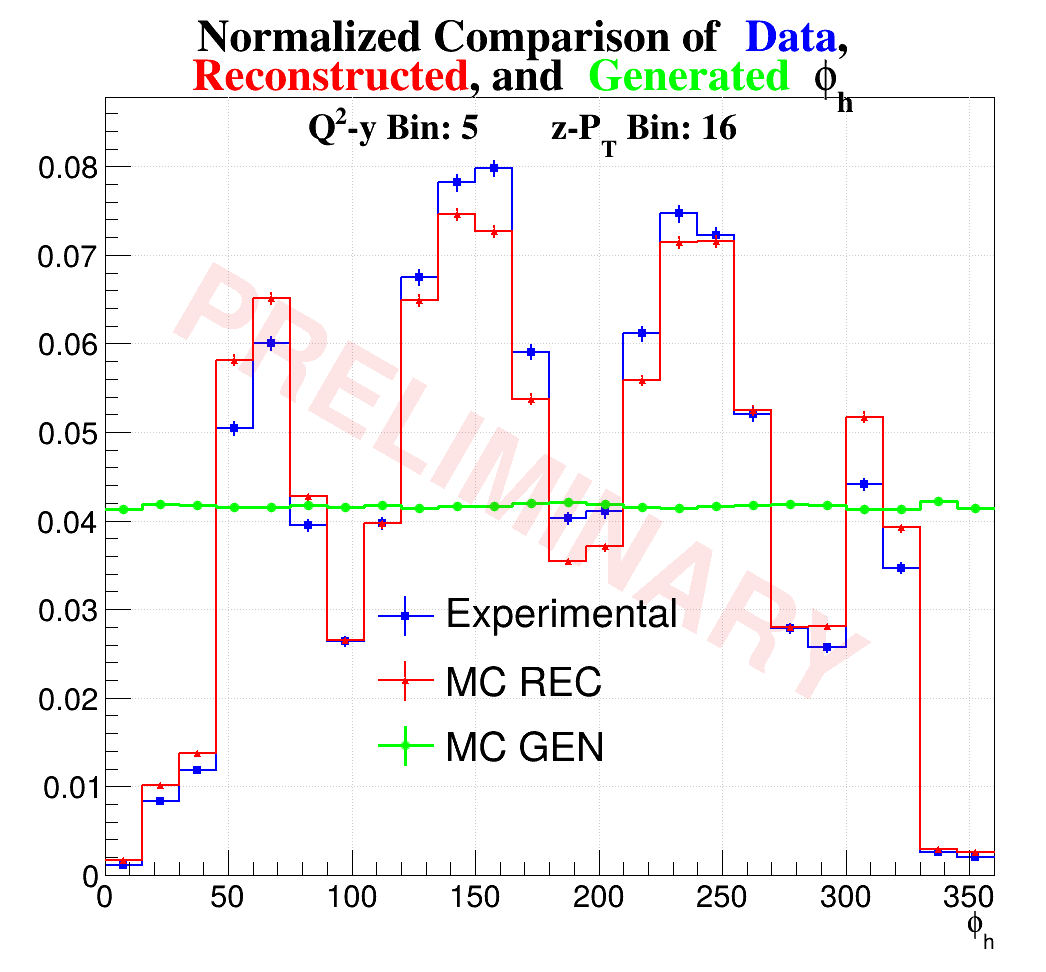

In [80]:
canvas_phi.Draw()

## Phi_h for data only

In [19]:
Q2_Y_BIN = 5
Z_PT_BIN = 16

# Q2_y_Histo_rdf_Initial_Name, z_pT_Histo_rdf_Initial_Name 
# results = search_keys(type_in=["1D"], source=["rdf", "mdf", "gdf"], smear=None, Q2_y_bin=[f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=[f"z_pT_Bin_{Z_PT_BIN}"], variable=["phi_t"], type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=not False, max_show=None, general_include=None, general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_{Q2_Y_BIN})_(z_pT_Bin_All)_(Q2)_(y)"])
rdf_Initial_Name, mdf_Initial_Name, gdf_Initial_Name = search_keys(type_in=["1D"], source=["rdf", "mdf", "gdf"], smear=None, Q2_y_bin=[f"Q2_y_Bin_{Q2_Y_BIN}"], z_pT_bin=[f"z_pT_Bin_{Z_PT_BIN}"], variable=None, type_in_filter=[], source_filter=[], Q2_y_bin_filter=[], z_pT_bin_filter=[], variable_filter=[], verbose=not False, max_show=None, general_include=["phi_t"], general_exclude=["(xB)", "EvGen", "(Q2_y_Bin_All)_(z_pT_Bin_All)_(z)_(pT)", f"(Q2_y_Bin_{Q2_Y_BIN})_(z_pT_Bin_All)_(Q2)_(y)"])

print(f"rdf_Initial_Name = {rdf_Initial_Name}")
print(f"mdf_Initial_Name = {mdf_Initial_Name}")
print(f"gdf_Initial_Name = {gdf_Initial_Name}")

# canvas_phi = ROOT.TCanvas("c_phi", "Histogram Canvas", 788, 750)
canvas_phi = ROOT.TCanvas("c_phi", "Histogram Canvas", 1050, 1000)

canvas_phi.Draw()

ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetRightMargin(0.05)  # increase from default ~0.1

rdf_Initial = TTree_Input.Get(rdf_Initial_Name)
mdf_Initial = TTree_Input.Get(mdf_Initial_Name)
gdf_Initial = TTree_Input.Get(gdf_Initial_Name)

ExREAL_1D_Norm = rdf_Initial
# ExREAL_1D_Norm = rdf_Initial.DrawNormalized("H P E0 same")
# MC_REC_1D_Norm = mdf_Initial.DrawNormalized("H P E0 same")
# MC_GEN_1D_Norm = gdf_Initial.DrawNormalized("H P E0 same")

# Max_Pre_Unfolded = max([ExREAL_1D_Norm.GetBinContent(ExREAL_1D_Norm.GetMaximumBin()), MC_REC_1D_Norm.GetBinContent(MC_REC_1D_Norm.GetMaximumBin()), MC_GEN_1D_Norm.GetBinContent(MC_GEN_1D_Norm.GetMaximumBin())])

# ExREAL_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)
# MC_REC_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)
# MC_GEN_1D_Norm.GetYaxis().SetRangeUser(0, 1.1*Max_Pre_Unfolded)

ExREAL_1D_Norm.GetXaxis().SetRangeUser(0, 360)
# MC_REC_1D_Norm.GetXaxis().SetRangeUser(0, 360)
# MC_GEN_1D_Norm.GetXaxis().SetRangeUser(0, 360)
    
# ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
ExREAL_1D_Norm.SetLineColor(root_color.Blue)
ExREAL_1D_Norm.SetLineWidth(2)
ExREAL_1D_Norm.SetLineStyle(1)
ExREAL_1D_Norm.SetMarkerColor(root_color.Blue)
ExREAL_1D_Norm.SetMarkerSize(1)
ExREAL_1D_Norm.SetMarkerStyle(21)
# #####==========#####      MC REC Histogram       #####==========##### ################################################################
# # ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
# ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
# MC_REC_1D_Norm.SetLineColor(root_color.Red)
# MC_REC_1D_Norm.SetLineWidth(2)
# MC_REC_1D_Norm.SetLineStyle(1)
# MC_REC_1D_Norm.SetMarkerColor(root_color.Red)
# MC_REC_1D_Norm.SetMarkerSize(1)
# MC_REC_1D_Norm.SetMarkerStyle(22)
# #####==========#####      MC GEN Histogram       #####==========##### ################################################################
# # ExREAL_1D_Norm.GetYaxis().SetTitle("Normalized")
# ExREAL_1D_Norm.GetXaxis().SetTitle("#phi_{h}")
# MC_GEN_1D_Norm.SetLineColor(root_color.Green)
# MC_GEN_1D_Norm.SetLineWidth(3)
# MC_GEN_1D_Norm.SetLineStyle(1)
# MC_GEN_1D_Norm.SetMarkerColor(root_color.Green)
# MC_GEN_1D_Norm.SetMarkerSize(1)
# MC_GEN_1D_Norm.SetMarkerStyle(20)

ExREAL_1D_Norm.SetStats(0)
# MC_REC_1D_Norm.SetStats(0)
# MC_GEN_1D_Norm.SetStats(0)

ExREAL_1D_Norm.Draw("H P E0 same")

# line1 = ROOT.TLatex(0.5, 0.96, "Normalized Comparison of #color[4]{Data},")
# line1.SetNDC(True)
# line1.SetTextAlign(23)   # centered horizontally, top-aligned vertically
# line1.SetTextFont(22)
# line1.SetTextSize(0.035)
# line1.Draw()

# # Second line: "#color[2]{Reconstructed}, and #color[3]{Generated} #varphi_{h}"
# line2 = ROOT.TLatex(0.5, 0.91, "#color[2]{Reconstructed}, and #color[3]{Generated} #varphi_{h}")
# line2.SetNDC(True)
# line2.SetTextAlign(23)
# line2.SetTextFont(22)
# line2.SetTextSize(0.035)
# line2.Draw()

# line1_phi = ROOT.TLatex(0.5, 0.98, "Normalized Comparison of #color[4]{Data},")
# line1_phi.SetNDC(True)
# line1_phi.SetTextAlign(23)   # 2 = center horizontally, 3 = top align vertically
# line1_phi.SetTextFont(22)
# line1_phi.SetTextSize(0.05)
# line1_phi.Draw()

# line2_phi = ROOT.TLatex(0.5, 0.94, "#color[2]{Reconstructed}, and #color[3]{Generated} #phi_{h}")
# line2_phi.SetNDC(True)
# line2_phi.SetTextAlign(23)   # same centering, stacked below
# line2_phi.SetTextFont(22)
# line2_phi.SetTextSize(0.05)
# line2_phi.Draw()

line2_phi = ROOT.TLatex(0.5, 0.94, "CLAS12 RG-A Experimental Data for #phi_{h}")
line2_phi.SetNDC(True)
line2_phi.SetTextAlign(23)   # same centering, stacked below
line2_phi.SetTextFont(22)
line2_phi.SetTextSize(0.05)
line2_phi.Draw()

line3_phi = ROOT.TLatex(0.5, 0.89, f"#color[1]{{Q^{{2}}-y Bin: {Q2_Y_BIN}        z-P_{{T}} Bin: {Z_PT_BIN}}}")
line3_phi.SetNDC(True)
line3_phi.SetTextAlign(23)   # same centering, stacked below
line3_phi.SetTextFont(22)
line3_phi.SetTextSize(0.04)
line3_phi.Draw()

prelim_phi = ROOT.TLatex(0.5, 0.5, "PRELIMINARY")
prelim_phi.SetNDC(True)                         # position in normalized coordinates
prelim_phi.SetTextAlign(22)                     # center horizontally & vertically
prelim_phi.SetTextSize(0.125)                    # adjust size to taste
prelim_phi.SetTextColorAlpha(ROOT.kRed, 0.1)    # red, 90% transparent (alpha = 0.1)
prelim_phi.SetTextAngle(-30)                     # rotate 30 degrees
prelim_phi.Draw()



# Legends_REC = ROOT.TLegend(0.35, 0.2, 0.65, 0.4)
# Legends_REC.SetNColumns(1)
# Legends_REC.SetBorderSize(0)
# Legends_REC.SetFillColor(0)
# Legends_REC.SetFillStyle(0)
# Legends_REC.AddEntry(ExREAL_1D_Norm, "#scale[2]{Experimental}", "lpE")
# Legends_REC.AddEntry(MC_REC_1D_Norm, "#scale[2]{MC REC}", "lpE")
# Legends_REC.AddEntry(MC_GEN_1D_Norm, "#scale[2]{MC GEN}", "lpE")

# Legends_REC.Draw()

canvas_phi.Update()

Found 3 matches
   (1D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
   (1D)_(mdf)_(SMEAR=Smear)_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
   (1D)_(gdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
rdf_Initial_Name = (1D)_(rdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
mdf_Initial_Name = (1D)_(mdf)_(SMEAR=Smear)_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)
gdf_Initial_Name = (1D)_(gdf)_(SMEAR='')_(Q2_y_Bin_5)_(z_pT_Bin_16)_(phi_t)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_phi


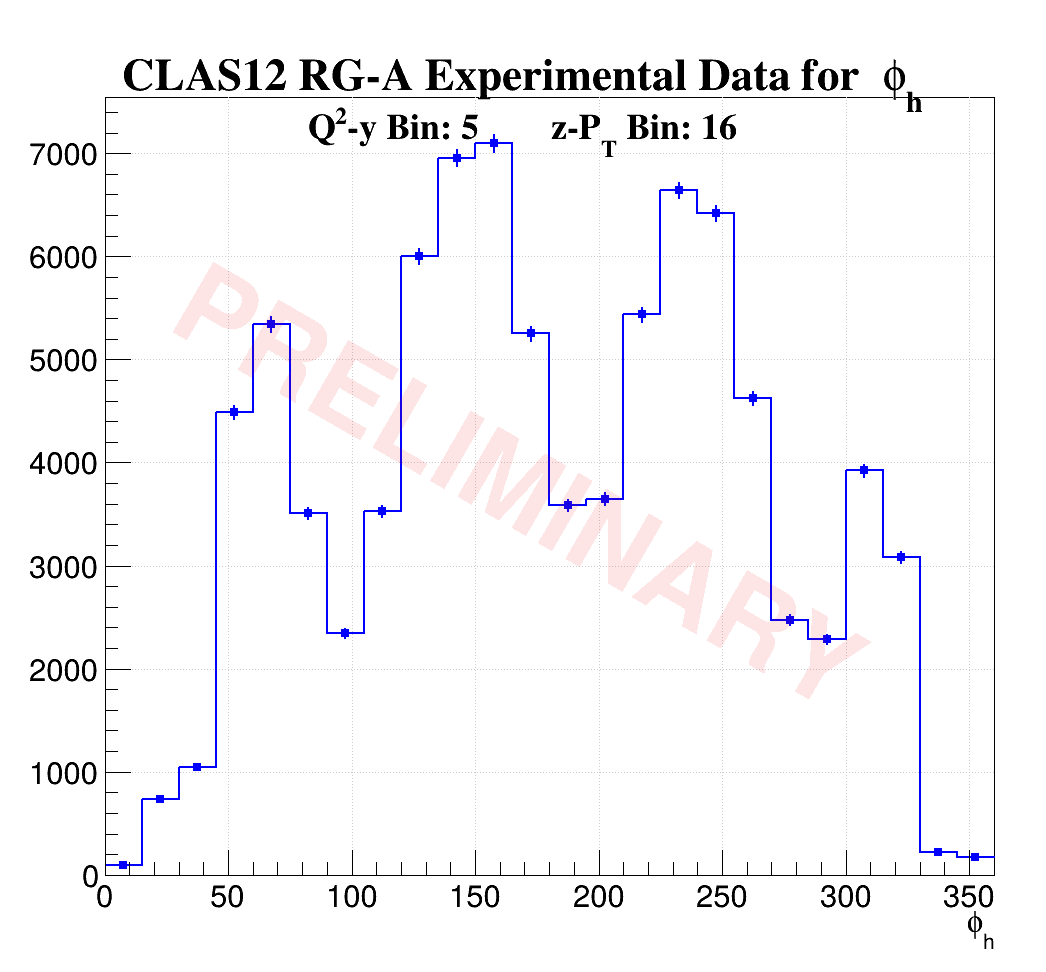

In [18]:
canvas_phi.Draw()